In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.dummy import DummyClassifier
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst","Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

In [3]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.3, stratify=label, random_state=3)

x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size=0.5, stratify=y_train, random_state = 3)

## Initial Model

In [4]:
rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=12)
rfc_og.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=12)

In [5]:
def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

y_pred = rfc_og.predict(x_val)
bench_marks(y_val, y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        74

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199

[[125   0]
 [  0  74]]
Accuracy: 1.0
Recall: 1.0
Precision: 1.0


## Feature Selection

In [6]:
feature_scores = pd.Series(rfc_og.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print(feature_scores)
feature_scores = feature_scores.index.tolist() # For later use

ConcavePointsWorst       0.187844
ConcavePoints            0.181702
RadiusWorst              0.169291
Concavity                0.071492
Radius                   0.069730
ConcavityWorst           0.064862
CompactnessWorst         0.035458
RadiusSE                 0.032513
Compactness              0.029947
TextureWorst             0.025794
Texture                  0.025272
SymmetrySE               0.011501
ConcavePointsSE          0.011384
Smoothness               0.010588
SymmetryWorst            0.010233
SmoothnessWorst          0.009942
ConcavitySE              0.009601
SmoothnessSE             0.007943
TextureSE                0.007174
FractalDimension         0.006952
FractalDimensionWorst    0.006216
CompactnessSE            0.005797
FractalDimensionSE       0.005017
Symmetry                 0.003747
dtype: float64


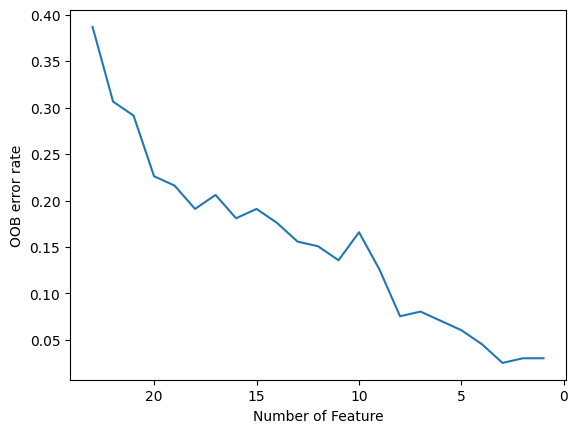

In [7]:
idx = []
error_rate = []
tempx = x_val
f_rm = 0
rfc_og = RandomForestClassifier(n_estimators=100, oob_score=True, bootstrap=True, random_state=3)

for i in feature_scores:
    rfc_og.fit(tempx, y_val)
    oob_error = 1 - rfc_og.oob_score_
    error_rate.append(oob_error)

    f_rm += 1
    idx.append(f_rm)

    tempx = tempx.drop(i, axis = 1)
    if len(tempx.columns) <= 1:
        break
plt.plot(idx, error_rate)
plt.xlabel("Number of Feature")
plt.ylabel("OOB error rate")
plt.gca().invert_xaxis()
plt.show()

In [8]:
rfecv = RFECV(estimator=rfc_og, step=1, cv=5,scoring='accuracy')
rfecv = rfecv.fit(x_train, y_train)
print("Removed n features:", rfecv.n_features_)
print(x_train.columns[rfecv.support_])
feature_select = feature[x_train.columns[rfecv.support_]]

Removed n features: 16
Index(['Radius', 'Texture', 'Compactness', 'Concavity', 'ConcavePoints',
       'RadiusSE', 'CompactnessSE', 'ConcavitySE', 'RadiusWorst',
       'TextureWorst', 'SmoothnessWorst', 'CompactnessWorst', 'ConcavityWorst',
       'ConcavePointsWorst', 'SymmetryWorst', 'FractalDimensionWorst'],
      dtype='object')


In [9]:
# New train/ validation/ test sets from new feature selection
x_train, x_test, y_train, y_test = train_test_split(feature_select, label, test_size=0.4, stratify=label, random_state=3)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, stratify=y_train, random_state=3)

In [10]:
rfc_og.fit(x_train, y_train)

y_pred = rfc_og.predict(x_val)
bench_marks(y_val, y_pred)

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       107
           1       0.94      0.92      0.93        64

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171

[[103   4]
 [  5  59]]
Accuracy: 0.9473684210526315
Recall: 0.921875
Precision: 0.9365079365079365


## Hyperparameter Tuning

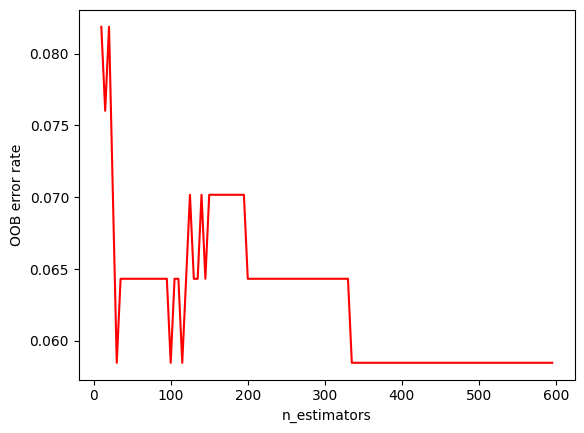

In [11]:
#Helps us decide how many n_estimators to use
idx = []
error_rate = []
min_estimators = 10
max_estimators = 600

for i in range(min_estimators, max_estimators - 1, 5):
    rfc_og.set_params(n_estimators=i)
    rfc_og.fit(x_val, y_val)
    oob_error = 1 - rfc_og.oob_score_
    idx.append(i)
    error_rate.append(oob_error)

plt.plot(idx, error_rate, "-r")
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

In [12]:
n_estimators = [100]
max_depth = [5, 6, 7, 8, 9, 10, 11, 12,13, 14, 15, 16, 17]
max_features = ["sqrt", "log2", None]
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]
min_samples_leaf = [1, 2, 3, 4, 5, 7]
criterion=['gini', 'entropy']

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'criterion': criterion}

# Not doing bootstrap, as must be set to true for when we need OOB

In [13]:
rf_random = RandomizedSearchCV(estimator = rfc_og, param_distributions = random_grid, n_iter = 200, cv = 5, n_jobs = -1, random_state=3)
rf_random.fit(x_train, y_train)
rfc_best = rf_random.best_estimator_

In [14]:
y_pred = rfc_best.predict(x_val)
print(rf_random.best_estimator_)
print(f'Accuracy: {accuracy_score(y_val, y_pred)}')
print(f'Recall: {recall_score(y_val, y_pred)}')
print(f'Precision: {precision_score(y_val, y_pred)}')

RandomForestClassifier(max_depth=14, min_samples_leaf=7, min_samples_split=10,
                       oob_score=True, random_state=3)
Accuracy: 0.9415204678362573
Recall: 0.890625
Precision: 0.95


## Evaluating our Model

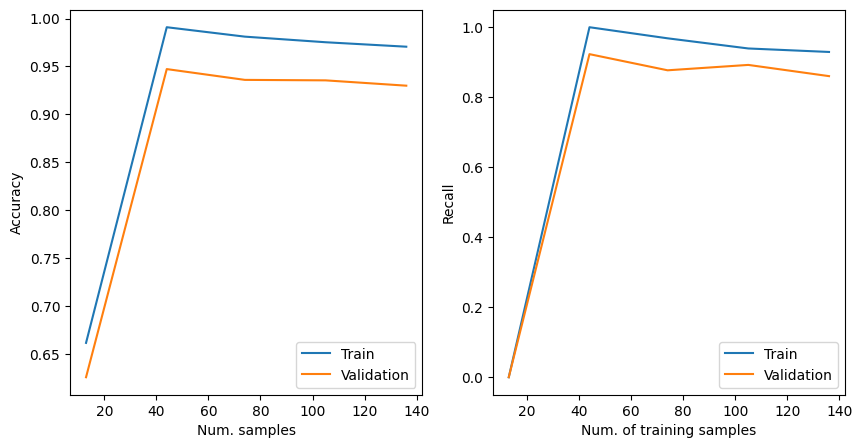

In [15]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc_best, X=x_val, y=y_val, scoring='accuracy', cv=5, random_state=3)
train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc_best, X=x_val, y=y_val, scoring='recall', cv=5, random_state=3)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []


for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Validation'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Validation'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

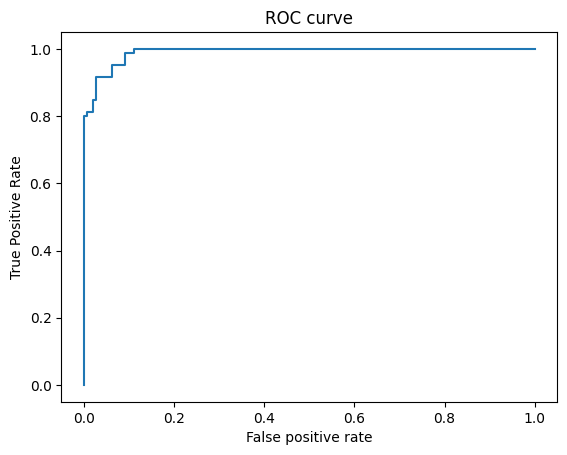

In [16]:
y_real_pred = rfc_best.predict(x_test)
auc = roc_auc_score(y_test, y_real_pred)

y_pred_prob = rfc_best.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()